# <center>ASTR4004/8004 - Neural Networks - Part 4</center>

This notebook builds autoencoders to generate handwritten digits.

We will train the network using handwritten digits from the Modified National Institute of Standards and Technology database (i.e., [MNIST dataset](http://yann.lecun.com/exdb/mnist/)), and construct the following architecture for our network

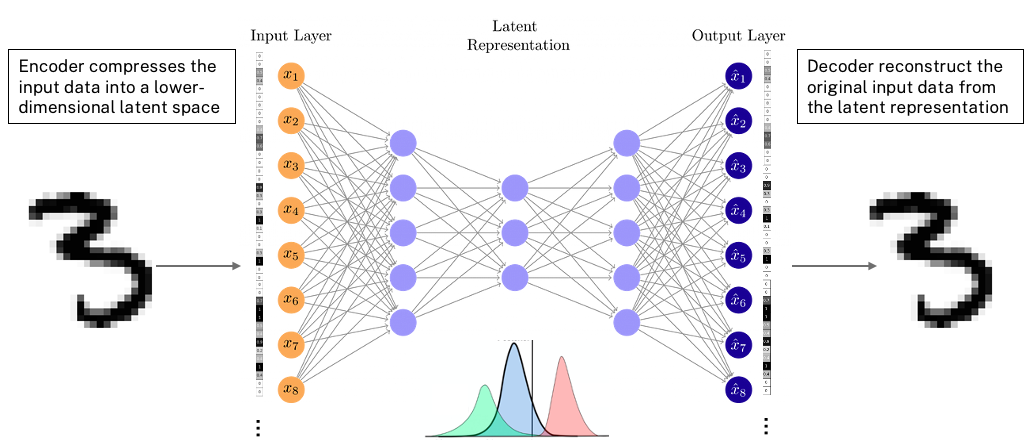

## Useful packages

In [1]:
# Let's work within our working directory, e.g., where MNIST data is stored
import os
os.chdir('/home/563/yq5547/notebooks/ASTR4004')

# We need numpy to handle data and array
import numpy as np

# We need matplotlib.pyplot to make plots
import matplotlib.pyplot as plt

# tensorflow and its keras API provide a NN framework
import tensorflow as tf
# Set the number of threads for intra and inter operations
tf.config.threading.set_intra_op_parallelism_threads(13)  # Set to your desired number
tf.config.threading.set_inter_op_parallelism_threads(13)

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Lambda

# set hyperparameters at the beginning
l_rate = 1e-4
Nepoch = 1000
batch_size = 64

2024-10-24 12:48:35.104700: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 12:48:35.512947: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 12:48:36.995016: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 12:48:37.030191: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 12:48:49.523608: W tensorflow/compiler/tf2t

## Dataset preparation
MNIST contains 70,000 images of handwritten digits, in greyscale with pixel-values from 0 to 255. Let us first load the data. I have store them in two seperated numpy files. But we only need the images here. Label is not needed.

In [2]:
# load data
images = np.load('./MNIST_images.npy', allow_pickle=True)
labels = np.load('./MNIST_labels.npy', allow_pickle=True)

# it is normally a good practice to rescale the training data into [0, 1] or [-1, 1]
images = (images - np.min(images)) / (np.max(images) - np.min(images))

# flatten images into 1D array
x = images.reshape([len(images), -1])

### Let's divide the sample into training (90%) and test (10%) 

In [3]:
train_size = int(0.9 * len(x)) # tensorflow can split some from training set for validation
test_size = len(x) - train_size

x_train, x_test = x[:train_size], x[test_size:]
images_test = images[test_size:]
labels_train = labels[:train_size]

print("Training data: {}".format(x_train.shape))
print("Test data: {}".format(x_test.shape))

Training data: (63000, 784)
Test data: (63000, 784)


### It is often a good practice to reshuffle the training set to get rid of any existing pattern in the data

In [4]:
shuffle_index = np.random.permutation(train_size)
x_train = x_train[shuffle_index]
labels_train = labels_train[shuffle_index]

shuffle_index = np.random.permutation(test_size)
x_test = x_test[shuffle_index]
images_test = images_test[shuffle_index]

## Network definition

In [5]:
input_dim = 28*28
hidden_dim = 512
latent_dim = 128
AE = 'VAE' #or 'CAE'

if AE == 'CAE': # Conventional Autoencoder
    encoder_input = Input(shape=(input_dim,))
    encoder_hidden = Dense(hidden_dim, activation='relu')(encoder_input)
    latent = Dense(latent_dim)(encoder_hidden)
    encoder = Model(encoder_input, latent)   
    
else: # Variational Autoencoder
    encoder_input  = Input(shape=(input_dim,))
    encoder_hidden = Dense(hidden_dim, activation='relu')(encoder_input)
    latent_mean    = Dense(latent_dim)(encoder_hidden)
    latent_logvar  = Dense(latent_dim)(encoder_hidden)
    
    def sampling(args):
        mean, logvar = args
        epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(mean)[0], latent_dim), mean=0., stddev=1.0)
        return mean + tf.keras.backend.exp(0.5 * logvar) * epsilon
    
    latent = Lambda(sampling)([latent_mean, latent_logvar])
    encoder = Model(encoder_input, latent)

decoder_input = Input(shape=(latent_dim,))
decoder_hidden = Dense(hidden_dim, activation='relu')(decoder_input)
decoder_output = Dense(input_dim)(decoder_hidden)
decoder = Model(decoder_input, decoder_output)

inputs  = Input(shape=(input_dim,))
latent  = encoder(inputs)
outputs = decoder(latent)
ae      = Model(inputs, outputs)

2024-10-24 12:49:13.464952: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Use the (untrained) autoencoder to create an image.

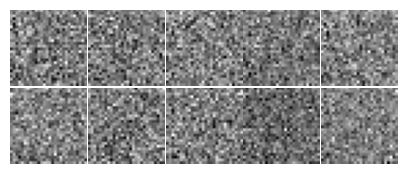

In [6]:
# Visualize generated images to see the training progress
latent_samples = tf.random.normal(shape=(10, latent_dim))
generated_images = decoder(latent_samples)    
plt.figure(figsize=(5, 2))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_images[i].numpy().reshape([28,28]), cmap='gray')
    plt.axis('off')
plt.subplots_adjust(wspace=0.02,hspace=0.02)       

## Network training

Epoch 1/1000, Loss: 0.3383
Epoch 11/1000, Loss: 0.1673
Epoch 21/1000, Loss: 0.1440
Epoch 31/1000, Loss: 0.1384
Epoch 41/1000, Loss: 0.1374
Early stopping at epoch 44


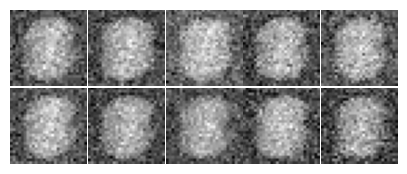

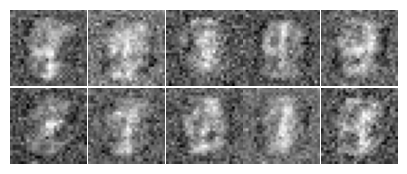

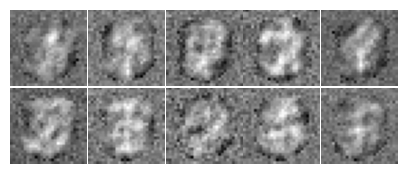

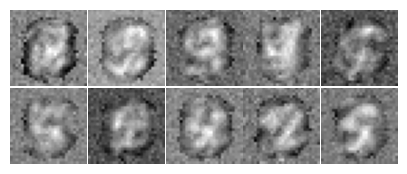

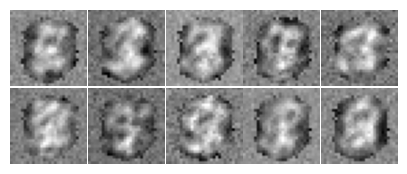

In [7]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(l_rate)
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

best_loss = np.inf # initialize to be infinity
wait = 0 # step count for no improvement
patience = 10 # number of epochs to wait for improvement

for epoch in range(Nepoch):
    epoch_loss = 0  # Accumulate loss for the epoch
    num_batches = 0

    for x in train_dataset:
             
        with tf.GradientTape() as tape:
        
            reconstructed = ae(x)
            
            loss = loss_fn(x, reconstructed)
                   
        grads = tape.gradient(loss, ae.trainable_variables)
        optimizer.apply_gradients(zip(grads, ae.trainable_variables))

        epoch_loss += loss.numpy()
        num_batches += 1
     
    # Calculate average loss for the epoch
    epoch_loss /= num_batches
       
    # Early stopping logic
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        wait = 0  # Reset wait counter
    else:
        wait += 1  # Increment wait counter if no improvement

    # Check if patience has been exceeded
    if wait >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

    # Visualize generated images to see the training progress
    if epoch%10 == 0:    
        print(f'Epoch {epoch+1}/{Nepoch}, Loss: {loss.numpy():.4f}')
        
        latent_samples = tf.random.normal(shape=(10, latent_dim))
        generated_images = decoder(latent_samples)    
        plt.figure(figsize=(5, 2))
        for i in range(10):
            plt.subplot(2, 5, i + 1)
            plt.imshow(generated_images[i].numpy().reshape([28,28]), cmap='gray')
            plt.axis('off')
        plt.subplots_adjust(wspace=0.02,hspace=0.02)

probably need to improve the architecture or be more patient

## Latent Space Visualization

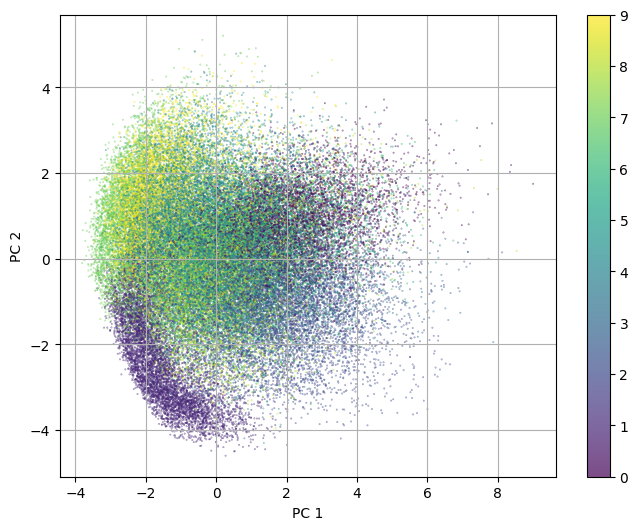

In [8]:
from sklearn.decomposition import PCA

# Assuming x_train and y_train are already defined and encoder is trained
latent_vectors = encoder(x_train).numpy()

# Use PCA for dimensionality reduction
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

# Plotting latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], 
                      c=labels_train.astype('int'), 
                      cmap='viridis', alpha=0.7, s=0.1)
plt.colorbar(scatter)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.show()

<font color='red'> give the CAE a try and explore its generative power and limits </font>